In [1]:
# imports
import json
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import sklearn
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from time import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor 
from statistics import mean

In [2]:
city = 'Bhopal'
PATH = f'/media/root/data/analysis/data/Item_wise_data/{city}/'

In [3]:
# data read
df1 = pd.read_excel(PATH+f'Item_wise-details-{city}-17-23-Dec-2021.xlsx')
df2 = pd.read_excel(PATH+f'Item_wise-details-{city}-24-31-Dec-2021.xlsx')

In [4]:
# exclude non baking items
df = pd.concat([df1, df2])
df = df[pd.notna(df['Oven_Time'])]
df = df.sort_values(by =['Kitchen_Display_Time', 'Location_Code', 'Order_Number'])

In [5]:
print(df.shape)
df = df.drop(['storedesc', 'city', 'Customer_Code', 'Customer_Name', 'Actual_Order_Date', 'Order_Status_Code', 'Order_Type_Code', 'Order_Saved', 'Order_Time', 'Driver_ID', 'Driver_Shift', 'Route_Time', 'Return_Time', 'Delayed_Order', 'Order_Taker_ID','Order_Taker_Shift', 'Closed_Order_Time', 'Customer_Address_Id', 'Original_Location_Code', 'Order_Id',], axis=1)
print(df.shape)
df['Kitchen_Display_Time'] = pd.to_datetime(df['Kitchen_Display_Time'])
df['Oven_Time'] = pd.to_datetime(df['Oven_Time'])
df['prep_time'] = df['Oven_Time'] - df['Kitchen_Display_Time']
df['prep_time'] = round(df['prep_time']/np.timedelta64(1, 's')).astype(int) + 7*60
print(df.shape)
df.head()

(84558, 27)
(84558, 7)
(84558, 8)


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,prep_time
4250,DPI66221,2021-12-17,1,2021-12-17 10:58:16.347,2021-12-17 10:58:31.240,BRD0020,BR-Garlic Breadsticks,435
32961,DPI66221,2021-12-17,1,2021-12-17 10:58:16.347,2021-12-17 10:58:30.833,PIZ0117,_SV-Margherita,434
26674,DPI66373,2021-12-17,1,2021-12-17 10:58:35.500,2021-12-17 11:03:53.140,PIZ5127,PM Loaded NV,738
28840,DPI66373,2021-12-17,1,2021-12-17 10:58:35.500,2021-12-17 11:03:52.823,PIZ0140,PM Loaded VG,737
36120,DPI66449,2021-12-17,1,2021-12-17 11:01:13.280,2021-12-17 11:02:13.377,PIZ0134,Pizza Mania Tomato,480


In [6]:
allMenuCodes = df['Menu_Code'].unique()
allStoreIds = df['Location_Code'].unique()

In [7]:
sampleItem=None
for index, item in df.iterrows():
    sampleItem = item
    break

In [8]:
sampleItem

Location_Code                             DPI66221
Order_Date                     2021-12-17 00:00:00
Order_Number                                     1
Kitchen_Display_Time    2021-12-17 10:58:16.347000
Oven_Time               2021-12-17 10:58:31.240000
Menu_Code                                  BRD0020
Item Description             BR-Garlic Breadsticks
prep_time                                      435
Name: 4250, dtype: object

In [9]:
# Feature 1: store id
def getOneHotEncodingStore(storeId, stores=allStoreIds):
    oneHotEncodingList = []
    for i in range(0, len(stores)):
        if(stores[i] == storeId):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

# returns the feature store id for an order
def getStoreId(item, isOneHotEncodingRequired=False):
    if isOneHotEncodingRequired:
        return getOneHotEncodingStore(item['Location_Code'], allStoreIds)
    else:
        return [item['Location_Code']]

In [10]:
print(getStoreId(sampleItem))
print(getStoreId(sampleItem, True))

['DPI66221']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
# Feature 2: Item Type
def getOneHotEncodingItem(item, items=allMenuCodes, clubCategoryWise=False):
    if clubCategoryWise:
        newItemsList = []
        newItemsList = [i[0:3] for i in items]
        unique_items = list(dict.fromkeys(newItemsList))
        return getOneHotEncodingItem(item[0:3], unique_items, False)
    
    oneHotEncodingList=[]
    for i in range(0, len(items)):
        if (items[i] == item):
            oneHotEncodingList.append(1)
        else:
            oneHotEncodingList.append(0)
    return oneHotEncodingList

def getItemType(item, isOneHotEncodingRequired=False, clubCategoryWise=False):
    if (not isOneHotEncodingRequired):
        if clubCategoryWise:
            return [item['Menu_Code'][0:3]]
        return [item['Menu_Code']]
    else:
        return getOneHotEncodingItem(item['Menu_Code'], allMenuCodes, clubCategoryWise)

In [12]:
print(getItemType(sampleItem))
print(getItemType(sampleItem, True))
print(getItemType(sampleItem, clubCategoryWise=True))
print(getItemType(sampleItem, True, True))

['BRD0020']
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['BRD']
[1, 0, 0, 0, 0, 0, 0]


In [13]:
# Feature 3: TimeSlot of kitchen display time
total_slots = 24
def getTimeslot(dt, slots=total_slots):
	current = datetime(2011, 1, 1)
	t1 = current.time()
	t2 = dt.time()
	for i in range(0, slots):
		current = current + timedelta(minutes = 60*24/slots)
		if(current.time() > t2):
			return i
	return slots-1

def getOneHotEncodingTimeSlot(timeslot):
    oneHotEncodingList = []
    for i in range(0, 24):
        oneHotEncodingList.append(0)
    oneHotEncodingList[timeslot] = 1
    return oneHotEncodingList

def getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=False):
    timeslot = getTimeslot(item['Kitchen_Display_Time'], 24)
    if isOneHotEncodingRequired:
        return getOneHotEncodingTimeSlot(timeslot)
    else:
        return [timeslot]

In [14]:
def get_preparation_time(item):
    return item['prep_time']
# 	diff = item['Oven_Time'] - item['Kitchen_Display_Time']
# 	return diff.total_seconds() + 7*60

In [15]:
#DON"T RUN IT AGAIN AND AGAIN, it will take much more time
# Feature 4 : Count of all baking items of all orders received by the store in the last 20 minutes.

# Pre-preparation of data
df['pre_prep_time'] = 0

StoreWiseItems = {}
for index, item in df.iterrows():
    store = item['Location_Code']
    if store in StoreWiseItems:
        dtKitchenDisplay = item['Kitchen_Display_Time']
        lastTime = dtKitchenDisplay - timedelta(minutes=60)
        count = 0
        pt = 0
        for i in reversed(range(len(StoreWiseItems[store]))):
            if(StoreWiseItems[store][i]['Kitchen_Display_Time'] >= lastTime and StoreWiseItems[store][i]['Kitchen_Display_Time'] < dtKitchenDisplay):
                if(StoreWiseItems[store][i]['Menu_Code'] == item['Menu_Code']):
                    pt += get_preparation_time(item)
                    count+=1
            else:
                break
        if count != 0:
            df['pre_prep_time'][index] = pt/count
        else:
            df['pre_prep_time'][index] = 10*60
        StoreWiseItems[store].append(item)
    else:
        StoreWiseItems[store] = [item]
        df['pre_prep_time'][index] = 10*60

        
storeWiseCumulativeItems = {}
StoreWiseDFs = {}
for store in StoreWiseItems.keys():
    StoreWiseDFs[store] = pd.DataFrame.from_dict(StoreWiseItems[store])
    storeWiseCumulativeItems[store] = {}

# item count per slot
for store in StoreWiseItems.keys():
    for item in StoreWiseItems[store]:
        date = item['Order_Date']
        minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
        if date in storeWiseCumulativeItems[store]:
            storeWiseCumulativeItems[store][date][minuteSlot]+=1
        else:
            t = []
            for i in range(0, 24*60):
                t.append(0)
            storeWiseCumulativeItems[store][date] = t
            storeWiseCumulativeItems[store][date][minuteSlot] = 1
            
#prefix sum            
for store in storeWiseCumulativeItems.keys():
    for date in storeWiseCumulativeItems[store].keys():
        for i in range(1, 24*60):
            storeWiseCumulativeItems[store][date][i] += storeWiseCumulativeItems[store][date][i-1]
            
            
def countPastOrders(item, storeWiseCumulativeItems=storeWiseCumulativeItems, slotTime=30):
    minuteSlot = getTimeslot(item['Kitchen_Display_Time'], 24*60)
    total = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][minuteSlot]
    prev = storeWiseCumulativeItems[item['Location_Code']][item['Order_Date']][max(minuteSlot-slotTime, 0)]
    return [(total-prev)]

/tmp/ipykernel_59665/2016951000.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_59665/2016951000.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = 10*60
/tmp/ipykernel_59665/2016951000.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_prep_time'][index] = pt/count


In [16]:
print(countPastOrders(sampleItem))
print(countPastOrders(sampleItem, slotTime=10))

d = datetime.strptime('2021-12-20 00:00:00', '%Y-%m-%d %H:%M:%S')
# storeWiseCumulativeItems[sampleItem['Location_Code']][d]

[2]
[2]


In [17]:
type(StoreWiseItems[sampleItem['Location_Code']])

list

In [18]:
# Feature 5 : Avg prep time of the same item in the same store in last 60 minutes.

def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
    orderedItem = item['Menu_Code']
    prepTime = []
    if clubCategoryWise:
        orderedItem = orderedItem[0:3]
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
             & (d['Kitchen_Display_Time'] >= lastTime) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]

    if(len(tdf)>0):
        return [tdf['prep_time'].mean()]
    else:
        return [10*60]


# def getPreviousPrepTime(item, StoreWiseItems=StoreWiseItems, clubCategoryWise=False, timeslot = 60):
#     dtKitchenDisplay = item['Kitchen_Display_Time']
#     lastTime = dtKitchenDisplay - timedelta(minutes=timeslot)
    
#     orderedItem = item['Menu_Code']
#     prepTime = []
#     if clubCategoryWise:
#         orderedItem = orderedItem[0:3]
#     tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
#              & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]

#     if(len(tdf)>0):
#         return [tdf['prep_time'].mean()]
#     else:
#         return [10*60]

    
# Feature 6 : Length of the queue in the store at that time
def lengthQueue(item):
    dtKitchenDisplay = item['Kitchen_Display_Time']
    d = StoreWiseDFs[item['Location_Code']]
    tdf = d[(d['Oven_Time'] >= dtKitchenDisplay) & (d['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    
#     prepTime = []
#     tdf = df[(df['Location_Code']==item['Location_Code']) & \
#              (df['Oven_Time'] >= dtKitchenDisplay) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
    return len(tdf.index)
#     for order in StoreWiseItems[item['Location_Code']]:
#         if(order['Kitchen_Display_Time'] >= lastTime and order['Kitchen_Display_Time'] <= dtKitchenDisplay):
#             if (order['Menu_Code'][0:len(orderedItem)] == orderedItem):
#                 prepTime.append(get_preparation_time(order))
#     if(len(prepTime) > 0):
#         return [mean(prepTime)]
#     else:
#         return [10*60] # POINT OF DISCUSSION, For now taking 10 minutes

In [19]:
getPreviousPrepTime(sampleItem, StoreWiseItems, False, 60)
lengthQueue(sampleItem)

2

In [20]:
item = sampleItem
orderedItem = item['Menu_Code']
orderedItem = orderedItem[0:3]
dtKitchenDisplay = item['Kitchen_Display_Time']
lastTime = dtKitchenDisplay - timedelta(minutes=60)
tdf = df[(df['Location_Code']==item['Location_Code']) & (df['Menu_Code'].str[0:len(orderedItem)]==orderedItem) \
         & (df['Kitchen_Display_Time'] >= lastTime) & (df['Kitchen_Display_Time'] <= dtKitchenDisplay)]
print(item, len(tdf)) 
if(len(tdf)>0):
    print([round(tdf['prep_time'].mean())])
tdf

Location_Code                             DPI66221
Order_Date                     2021-12-17 00:00:00
Order_Number                                     1
Kitchen_Display_Time    2021-12-17 10:58:16.347000
Oven_Time               2021-12-17 10:58:31.240000
Menu_Code                                  BRD0020
Item Description             BR-Garlic Breadsticks
prep_time                                      435
Name: 4250, dtype: object 1
[435]


,Location_Code,Order_Date,Order_Number,Kitchen_Display_Time,Oven_Time,Menu_Code,Item Description,prep_time,pre_prep_time
4250,DPI66221,2021-12-17,1,2021-12-17 10:58:16.347,2021-12-17 10:58:31.240,BRD0020,BR-Garlic Breadsticks,435,561


In [21]:
# global variables

isThresholdForPreparationTime = False
thresholdForPreparationTime = 30 # minutes for preparation time (threshold)

clubItemsCategoryWise = False

splitMethod = 'random'
slotTimeForPastOrders = 20 # minutes

model = 'RF'
isOneHotEncodingRequired = True
isNormalizationRequired = True

In [22]:
sampleItem

Location_Code                             DPI66221
Order_Date                     2021-12-17 00:00:00
Order_Number                                     1
Kitchen_Display_Time    2021-12-17 10:58:16.347000
Oven_Time               2021-12-17 10:58:31.240000
Menu_Code                                  BRD0020
Item Description             BR-Garlic Breadsticks
prep_time                                      435
Name: 4250, dtype: object

In [23]:
# RUN IT AGAIN AND AGAIN TO CHECK THE IMPORTANCE OF THE FEATURE
X_train, X_test, y_train, y_test = [], [], [], []
X = []
y = []
import time
t1 = t2 = t3 = t4 = t5 = t6 = t7 = 0
i = 0
for index, item in df.iterrows():
    i+=1
    if(i%1000==0): print(t1, t2, t3, t4, t5, t6, t7)
    if(isThresholdForPreparationTime and (get_preparation_time(item) > thresholdForPreparationTime*60)): #removing inputs 
        continue
        
    features = []
    t = time.time()
    features = features + getStoreId(item, isOneHotEncodingRequired)
    t1 += time.time() - t
    
    t = time.time()
    features = features + getItemType(item, isOneHotEncodingRequired=isOneHotEncodingRequired, clubCategoryWise=clubItemsCategoryWise)
    t2 += time.time() - t

    t = time.time()    
    features = features + getTimeSlotOfKitchenDisplayTime(item, isOneHotEncodingRequired=isOneHotEncodingRequired)
    t3 += time.time() - t

    t = time.time()
    features = features + countPastOrders(item, storeWiseCumulativeItems, slotTimeForPastOrders) 
    t4 += time.time() - t

    t = time.time()
    features = features + getPreviousPrepTime(item, clubCategoryWise=clubItemsCategoryWise, timeslot = 60)  
    t5 += time.time() - t

    t = time.time()    
    
    features = features + [lengthQueue(item)]
    
    t6 += time.time() - t
    t = time.time()
    X.append(features)
    
    y.append(get_preparation_time(item))
    t7 += time.time() - t

#     if((order['ORDER_DATE'] >='2021-12-20' and order['ORDER_DATE'] <= '2021-12-24') or (order['ORDER_DATE'] >='2021-12-27' and order['ORDER_DATE'] <= '2021-12-29')):
#         X_train.append(features)
#         y_train.append(420+round(get_preparation_time(order)))
#     elif(order['ORDER_DATE'] =='2021-12-30'):
#         X_test.append(features)
#         y_test.append(420+round(get_preparation_time(order)))
print(t1, t2, t3, t4, t5, t6, t7)

0.035752296447753906 0.040241241455078125 0.060504913330078125 1.334658145904541 5.4647417068481445 1.339904546737671 0.022867918014526367
0.07192516326904297 0.07909440994262695 0.12621355056762695 2.9655356407165527 10.751380443572998 2.656160593032837 0.044997453689575195
0.10735821723937988 0.11863541603088379 0.19392681121826172 4.733525037765503 16.12092614173889 3.954514741897583 0.06721854209899902
0.14258527755737305 0.15847468376159668 0.26581454277038574 6.671976804733276 21.590702056884766 5.260011434555054 0.0899055004119873
0.17690825462341309 0.19655108451843262 0.3272268772125244 8.119941234588623 26.869171857833862 6.551637411117554 0.11213302612304688
0.21245265007019043 0.2364051342010498 0.38994288444519043 9.560359716415405 32.22954058647156 7.863281965255737 0.13476014137268066
0.24790334701538086 0.27631402015686035 0.4558117389678955 11.1911141872406 37.54002642631531 9.15530776977539 0.15703845024108887
0.2838747501373291 0.3170487880706787 0.5252656936645508 1

2.2832067012786865 2.5588181018829346 4.248523950576782 107.0102744102478 339.8888075351715 83.3222827911377 1.4840877056121826
2.32100510597229 2.602790355682373 4.314615726470947 108.57470273971558 345.3863296508789 84.65197563171387 1.5087883472442627
2.3594179153442383 2.647552013397217 4.386985540390015 110.39013004302979 351.06610202789307 86.00627064704895 1.533137321472168
2.3979392051696777 2.6922786235809326 4.460047245025635 112.32988953590393 356.6143054962158 87.36284852027893 1.5576488971710205
2.4365317821502686 2.7368717193603516 4.531354665756226 114.14981603622437 362.2773928642273 88.73032999038696 1.582024335861206
2.474325180053711 2.7813968658447266 4.5975341796875 115.67600893974304 367.9684500694275 90.07011604309082 1.6065113544464111
2.5125396251678467 2.826176643371582 4.667999982833862 117.4580430984497 373.5422840118408 91.40848231315613 1.6306777000427246
2.5524747371673584 2.872603178024292 4.744813442230225 119.43108129501343 379.354056596756 92.80236768

In [24]:
if splitMethod == 'random':
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [25]:
def getRMSE(actual, predictions):
    mse = sklearn.metrics.mean_squared_error(actual, predictions)
    return math.sqrt(mse)

In [26]:
# random forest
if (model=='RF'):
    print("Random Forest Model")
    regressor = RandomForestRegressor()
    if(isNormalizationRequired):
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_train)
    print("RMSE score on train set: ", getRMSE(y_train, predictions))
        
    predictions = regressor.predict(X_test)
    print("RMSE score on test set: ", getRMSE(y_test, predictions))
    

Random Forest Model
RMSE score on train set:  15.527373609963119
RMSE score on test set:  40.65363294720847


In [27]:
predictions = regressor.predict(X_train)
print("RMSE score on train set: ", getRMSE(y_train, predictions))

predictions = regressor.predict(X_test)
print("RMSE score on test set: ", getRMSE(y_test, predictions))

RMSE score on train set:  15.527373609963119
RMSE score on test set:  40.65363294720847


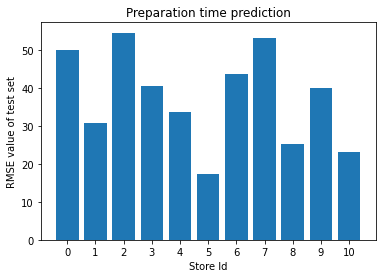

In [28]:
X_t = []
Y_t = []
for j in range(0, len(allStoreIds)):
    xx = []
    yy = []
    for i in range(0, len(X_test)):
        if(X_test[i][j] > 0):
            xx.append(X_test[i])
            yy.append(y_test[i])
    X_t.append(j)
    Y_t.append(getRMSE(yy, regressor.predict(xx)))
    
plt.bar(X_t, Y_t)
plt.xticks(X_t)
plt.xlabel("Store Id")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction")
plt.show()

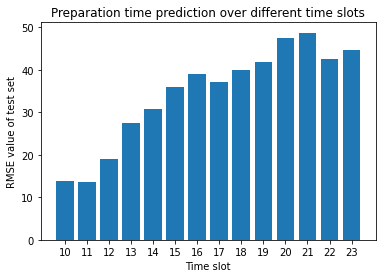

In [29]:
X_Axis = [i for i in range(10, 24)]
RMSETimeSlotWise = {}
total_items = len(allMenuCodes)+len(allStoreIds)
for x in X_Axis:
    x1 = []
    y1 = []
    for i in range(0, len(X_test)):
        if(X_test[i][total_items+x] > 0):
            x1.append(X_test[i])
            y1.append(y_test[i])
    RMSETimeSlotWise[x] = getRMSE(y1, regressor.predict(x1))
    
X_axis = list(RMSETimeSlotWise.keys())
Y_axis = list(RMSETimeSlotWise.values())

plt.bar(X_axis, Y_axis)
plt.xticks(X_axis)
plt.xlabel("Time slot")
plt.ylabel("RMSE value of test set")
plt.title("Preparation time prediction over different time slots")
plt.show()

In [89]:
# #activation: relu, logistic
# def ModelResults(X_train, X_test, y_train, y_test, model, isNormalizationRequired=True):
    
#     if(isNormalizationRequired):
#         scaler = StandardScaler()
#         scaler.fit(X_train)

#         X_train = scaler.transform(X_train)
#         X_test = scaler.transform(X_test)
        
#     if(model=='NN'):
#         hidden_layer_sizes=(80, 30, 10)
#         activation='relu'
#         print("Neural Network model")
#         print("Hidden layers: ", hidden_layer_sizes)
#         print("Activation function: ", activation)
#         mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, max_iter=1000, verbose=True, learning_rate='constant', learning_rate_init=0.01)
#         mlp.fit(X_train, y_train)
#         print(mlp.best_loss_)
        
#         predictions = mlp.predict(X_train)
#         print("RMSE score on validation set: ", getRMSE(y_train, predictions))
        
#         predictions = mlp.predict(X_test)
#         print("RMSE score on test set: ", getRMSE(y_test, predictions))
        
#     elif(model=='RF'):
#         print("Random Forest Model")
#         regressor = RandomForestRegressor()
#         regressor.fit(X_train, y_train)
        
#         predictions = regressor.predict(X_train)
#         print("RMSE score on validation set: ", getRMSE(y_train, predictions))
        
#         predictions = regressor.predict(X_test)
#         print("RMSE score on test set: ", getRMSE(y_test, predictions))
#     else:
#         print("Model not implemented yet")

In [86]:
# mlp.predict_log_proba(X)

array([[ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       ...,
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635],
       [ -9.68770891,  -7.18229529,  -7.05802898, ..., -10.05756664,
        -11.47823238,  -9.53518635]])

In [ ]:

# scaler = StandardScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

# regressor = RandomForestRegressor()
# regressor.fit(X_train, y_train)
# predictions = regressor.predict(X_train)

In [ ]:
# mse = sklearn.metrics.mean_squared_error(y_train, predictions)  
# rmse = math.sqrt(mse)  
# rmse